# 🧠⬅️🎧 Decoding Acoustic Stimuli from EEG Data Using Backward Models

In this notebook, we will learn the basics of **linear backward models**. Our goal is to find out how we can *reconstruct* the audiobooks participants were listening to, using only their brain signals!


 **A Note on Our Data**
Just like in the previous notebook, we are working with **pre-processed and aligned data**. This means all the initial cleanup is already done:
> 
* **EEG Data:** Filtered between 1-8 Hz.
* **Speech Envelopes:** Pre-calculated and also filtered between 1-8 Hz.


Also note, that for demonstration purposes, we only analyze data from a single subject (it makes the calculation much quicker)

# EEG Data Analysis: Seminar Notebook

In this notebook, you will process your own EEG data step by step — data that you recorded while listening to an audiobook.

## Learning Objectives
- Understand the EEG data structure  
- Perform Independent Component Analysis (ICA)
- Apply average referencing
- Apply preprocessing: filtering (notch, frequency bands, causal vs. non-causal)  
- Align EEG and audio data (StimTrak signal)  

In [1]:
# Imports
import numpy as np
from scipy.signal import correlate, correlation_lags
import librosa
import mne
from matplotlib import pyplot as plt
%matplotlib qt

from mne_icalabel import label_components
from matplotlib.cm import get_cmap

## Rename the channels

## Load and Visualize the raw EEG-Data

In [2]:
# 32-channel mapping (to rename the channels)
channel_map = {
    '1': 'Fp1',
    '2': 'Fp2',
    '3': 'F7',
    '4': 'F3',
    '5': 'Fz',
    '6': 'F4',
    '7': 'F8',
    '8': 'FC5',
    '9': 'FC1',
    '10': 'FC2',
    '11': 'FC6',
    '12': 'T7',
    '13': 'C3',
    '14': 'Cz',
    '15': 'C4',
    '16': 'T8',
    '17': 'CP5',
    '18': 'CP1',
    '19': 'CP2',
    '20': 'CP6',
    '21': 'P7',
    '22': 'P3',
    '23': 'Pz',
    '24': 'P4',
    '25': 'P8',
    '26': 'POz',
    '27': 'O1',
    '28': 'Oz',
    '29': 'O2',
    '30': 'FT9',
    '31': 'FT10',
    '32': 'TP9'
}

In [3]:
def process_and_set_montage(j_exp, raw_input, channel_map_32):
    # 1. choose original channel range
    # j=0: 1-32; j=1: 33-64; j=2: 65-96
    start_ch_num = (j_exp * 32) + 1
    end_ch_num = start_ch_num + 31 
    
    original_ch_names = [str(m) for m in range(start_ch_num, end_ch_num + 1)]
    
    # 2. choose channels (确保 raw_input 已经是 copy 过的)
    raw_processed = raw_input.pick_channels(original_ch_names)
    
    # 3. rename dictionary
    rename_dict = {}
    for i, original_name in enumerate(raw_processed.ch_names):
        # i 从 0 到 31。 new_standard_key 是字符串 '1' 到 '32'
        new_standard_key = str(i + 1)
        rename_dict[original_name] = channel_map_32[new_standard_key]

    raw_processed.rename_channels(rename_dict) 
    #4. set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_processed.set_montage(montage)
    
    return raw_processed

In [4]:
def apply_ica(raw):
    # Highpass-filter for ICA
    raw_ica = raw.copy().filter(1., 100., fir_design='firwin')
    
    # Aet Average Reference
    raw_ica.set_eeg_reference('average', projection=False)
    # raw_ica.plot()

    ica = mne.preprocessing.ICA(n_components=15, method='infomax', fit_params=dict(extended=True), random_state=97, max_iter='auto')
    ica.fit(raw_ica)

    # Classify components
    labels = label_components(raw_ica, ica, method='iclabel')
    print(labels['labels'])

    # define artifact labels
    artifact_labels = ['eye', 'muscle', 'heart', 'line_noise']
    artifact_comps = [i for i, label in enumerate(labels['labels']) if label in ['eye blink', 'muscle artifact']]
    ica.exclude = artifact_comps

    # ica.plot_components(picks=artifact_comps, title='ICLabel: Artefakt-Komponenten')
    # Apply ICA
    raw_clean = ica.apply(raw.copy())
    return raw_clean

In [5]:
#change between inline and qt to see the plots in the notebook or in a separate window
# %matplotlib inline #图像直接显示在 Jupyter Notebook 的输出单元格中
# %matplotlib qt #弹出独立窗口
from typing import Union
import librosa as lb
from scipy import signal


#helper function creating the envelope by using the hilbert transform
def get_envelope_from_hilbert(data: np.ndarray):
    analytic_signal = signal.hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

#helper function applying a Butterworth bandpass filter
def apply_butterworth_bandpass(data: Union[np.ndarray], order=4, cutoff_low=1, cutoff_high=20, fs=1000, axis=-1):
    sos = signal.butter(N=order, Wn=[cutoff_low, cutoff_high], btype="bandpass", fs=fs, output="sos")
    filtered = signal.sosfiltfilt(sos, data, axis=axis)
    return filtered

## Pad shorter signal with zeroes
def pad_zeros_right(s, padding_length):
    return np.pad(s, (0, padding_length), mode='constant', constant_values=0)

def padding(a, b, pad_function=None):
    if len(a) != len(b) and pad_function is None:
        raise ValueError(f"len(a)={len(a)} != len(b)={len(b)} and no pad_function provided")
    elif len(a) != len(b):
        if len(a) < len(b):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    return a, b

def crosscorrelation(ref, sig):
    # ref = StimTrak/EEG-reference, sig = audio
    c = correlate(ref, sig, mode='full')
    lags = correlation_lags(len(ref), len(sig), mode='full')
    return c, lags

## Load and Preprocessing EEG-Data

In [10]:
# Load audio wav-file
audios = []

for i in range(1, 16):
    filename = f"/Users/zhiyingliu/Desktop/FAU/3-semester/audio-computer/submission/audio_stimuli/M{str(i).zfill(2)}.wav"
    
    # Lade und resample direkt auf 1000 Hz
    stimuli, sr = librosa.load(filename, sr=fs)  # resample the audio data from 48kHz to 1kHz to align it with EEG
    
    #apply the hilbert transform to our stimuli to get the envelope
    envelope = get_envelope_from_hilbert(stimuli)

    #filter the envelope to get the delta band (1 - 4 Hz)
    delta_band = apply_butterworth_bandpass(envelope, order=4, cutoff_low=1, cutoff_high=4, fs=fs)
    
    #打印进度
    print(f'Processed M{str(i).zfill(2)}.wav, length={len(delta_band)}')

    audios.append(delta_band)

# print(delta_band_stimtrak.shape) #stimtrak
# print(sr)

Processed M01.wav, length=100656
Processed M02.wav, length=110920
Processed M03.wav, length=104384
Processed M04.wav, length=94032
Processed M05.wav, length=102328
Processed M06.wav, length=54704
Processed M07.wav, length=120072
Processed M08.wav, length=118856
Processed M09.wav, length=104656
Processed M10.wav, length=119040
Processed M11.wav, length=115840
Processed M12.wav, length=123528
Processed M13.wav, length=110192
Processed M14.wav, length=113736
Processed M15.wav, length=73176


In [12]:
import numpy as np
import h5py

raw_data = []
all_raws = []
stimtrak = {}
for session_i in range(1,6):
    # ==== Load EEG data ====
    eeg_path = f"/Users/zhiyingliu/Desktop/FAU/3-semester/audio-computer/submission/data/ABCI_Session{session_i}.vhdr"
    raw_session = mne.io.read_raw_brainvision(eeg_path, preload=True)

    stimtrak_data = raw_session.get_data()[-1,:] #105 channel
    stimtrak[session_i] = stimtrak_data

    # === Timeshifts 计算 (针对当前 Session) ===
    # 注意：如果每个Session的音频对齐不同，这里需要重新计算
    lag_samples_list = []
    # timeshift_s_list = [] # 如果后面没用到可以注释掉

    envelope_stimtrak = get_envelope_from_hilbert(stimtrak_data)    
    delta_band_stimtrak = apply_butterworth_bandpass(envelope_stimtrak, order=4, cutoff_low=1, cutoff_high=4, fs=fs)

    print("   正在计算 Audio Lags...")
    for i, audio in enumerate(audios, start=1):
        audio_p, stim_p = padding(audio, delta_band_stimtrak, pad_function=pad_zeros_right)
        corr, lags = crosscorrelation(stim_p, audio_p)
        peak_idx = np.argmax(np.abs(corr)) 
        lag_samples = lags[peak_idx]
        lag_samples_list.append(lag_samples)

    # === pick only 32 channels ===
    for j in range(3):
        #当前subject number
        subject_id = (session_i-1)*3+j+1
        
        raw_exp = raw_session.copy()
        raw_mon = process_and_set_montage(j, raw_exp, channel_map)
        # ===ICA processing===
        raw_clean = apply_ica(raw_mon)
        
        # ==Preprocessing: Filter EEG-Data==
        # Notch-Filter at 50 Hz (power line)
        raw_clean.notch_filter(freqs=50)
        all_raws.append(raw_clean)
        
        # ==EEG Delta Band (1 - 4 Hz)==
        delta = raw_clean.copy().filter(1., 4., fir_design='firwin')

        
        # ---------------------------------------------------------
        # 预处理代码前面已经生成了：
        # raw_clean : np.array, shape (n_channels, n_samples_total)
        # lag_samples_list : list of envelopes, each np.array(n_samples_i)
        # timeshift_s_list : 可忽略，不用存
        # ---------------------------------------------------------
        
        out_file = "backward_dataset.hdf5"
        
        # ========== Step 1: 将 raw_clean 按 envelope 长度切分 ==========
        eeg_mat = delta.get_data()
        eeg_trials = []
        env_trials = []
        
        #对eeg根据lag_sampling 样本点位置分
        for audio, lag in zip(audios, lag_samples_list):
            L = len(audio)          # trial 长度（1000 Hz）
            start = int(lag)
            stop = start + L
            eeg_trial = eeg_mat[:, start:stop]    # shape: (n_channels, L)
            env_trial = audio              # envelope 直接使用     # shape: (L,)
        
            eeg_trials.append(eeg_trial)
            env_trials.append(env_trial)
        
        # print(len(eeg_trials), len(env_trials))
        # print(eeg_trials[0].shape, env_trials[0].shape)
        
        # ========== Step 2: 降采样 ==========
        
        # --- 假设您已经得到了切分后的高采样率数据 ---
        current_fs = 1000
        target_fs = 128
        eeg_trials_low_fs = []
        env_trials_low_fs = []
        
        # --- 1. 降采样 EEG ---
        for eeg_trial in eeg_trials:
            n_samples_old = eeg_trial.shape[1]
            
            # 计算目标样本数
            n_samples_new = int(n_samples_old * target_fs / current_fs)
            
            # 初始化降采样后的 EEG 数组
            eeg_low_fs = np.zeros((eeg_trial.shape[0], n_samples_new))
            
            # 逐通道进行降采样（resample 需要对时间轴操作）
            for ch in range(eeg_trial.shape[0]):
                # resample 返回 (samples,)，需要赋值给 eeg_low_fs 的列
                eeg_low_fs[ch, :] = resample(eeg_trial[ch, :], n_samples_new)
                
            eeg_trials_low_fs.append(eeg_low_fs)
        
        # --- 2. 降采样 Envelope ---
        for env_trial in env_trials:
            # 形状是 (samples,)
            n_samples_old = env_trial.shape[0]
            
            # 计算目标样本数 (与 EEG 相同)
            n_samples_new = int(n_samples_old * target_fs / current_fs)
            
            # 对 Envelope 进行降采样
            env_low_fs = resample(env_trial, n_samples_new)
            
            env_trials_low_fs.append(env_low_fs)
        
        # 此时，eeg_trials_low_fs 和 env_trials_low_fs 就是您需要的降采样后的数据
        
        # ========== Step 3: 写入兼容的 HDF5 ==========
        # 模式必须是 "a" (append)，否则会覆盖之前的数据
        with h5py.File(out_file, "a") as f:
            n_trials = len(eeg_trials_low_fs)
            print(f"      -> 写入 Subject {subject_id} 到 HDF5...")

        
            for t in range(n_trials):
                trial_id = t + 1
        
                eeg = np.asarray(eeg_trials_low_fs[t])   # (channels, samples) 将输入转化为数组
                env = np.asarray(env_trials_low_fs[t])   # (samples,)
        
                # ---- EEG ----
                eeg_path = f"eeg/{subject_id}/{trial_id}"
                eeg_ds = f.create_dataset(eeg_path, data=eeg)
        
                # 给每个 trial 一个 stimulus 编号（老师 notebook 依赖这个）
                stim_code = f"s{subject_id}_t{trial_id}"
                eeg_ds.attrs["stimulus"] = stim_code
        
                # ---- envelope ----
                stim_group = f.require_group(f"stimulus_files/{stim_code}")
                stim_group.create_dataset("attended_env", data=env)
        
        print("写入完成：", out_file)


print(f"\n所有 Session 处理完成。文件保存为: {out_file}")

Extracting parameters from /Users/zhiyingliu/Desktop/FAU/3-semester/audio-computer/submission/data/ABCI_Session1.vhdr...
Setting channel info structure...
Reading 0 ... 1649719  =      0.000 ...  1649.719 secs...
   正在计算 Audio Lags...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.0s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 202.9s.
['other', 'muscle artifact', 'other', 'eye blink', 'brain', 'brain', 'other', 'other', 'other', 'muscle artifact', 'other', 'other', 'brain', 'muscle artifact', 'brain']
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff freq

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.2s finished


NameError: name 'resample' is not defined

In [ ]:
print(all_raws[0].info)
print(all_raws[0].shape)
print(stimtrak[1].shape)

## Alignment: EEG & Audio (StimTrak)

## load audio file

In [14]:
# --- Overlay-Plot ---
plt.figure(figsize=(14, 5))

# plot StimTrak
t_stim = np.arange(len(speech_stimulus_eeg)) / fs
plt.plot(t_stim, speech_stimulus_eeg,
         linewidth=1.5, alpha=1., label='StimTrak')

# colormap for audios
cmap = get_cmap('tab20')

stim_amp = np.nanmax(np.abs(speech_stimulus_eeg))

for i, (audio, lag_samples) in enumerate(zip(audios, lag_samples_list), start=1):
    if np.max(np.abs(audio)) == 0:
        scaled = audio
    else:
        scaled = (audio / np.max(np.abs(audio))) * (0.8 * stim_amp)

    # align the audio part by shifting it according to computed lags
    t_audio_shifted = (np.arange(len(audio)) + lag_samples) / fs

    # color
    color = cmap(i % cmap.N)

    plt.plot(t_audio_shifted, scaled,
             color=color, alpha=0.8,
             label=f"M{str(i).zfill(2)} ({lag_samples/fs:.3f}s)")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("StimTrak with aligned overlayed audio-signals")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/84/n7z137t10hl39svbf2_zh8g40000gn/T/ipykernel_8771/2345541329.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


# Decoding acoustic stimuli from EEG-data using backward models

In this notebook, we will learn the basics of linear backward models and how we can reconstruct the presented audio books from brain signals.

Again we are working with pre-processed and aligned data. This includes Filtering of EEG data and pre-calculated speech envelopes. Both 1-8Hz.

# 1. Import necessary libraries

In [57]:
root_dir = "/Users/zhiyingliu/Desktop/FAU/3-semester/audio-computer"

import os
import sys
import sklearn
if root_dir not in sys.path:
    sys.path.append(root_dir)
from models.ridge import Ridge
import h5py
import numpy as np
import seaborn as sns
import pingouin as pg

import matplotlib.pyplot as plt

# 2. Define constants and paths

In [58]:
data_file = os.path.join(root_dir, 'my_backward_dataset.hdf5')
Fs = 128

# 3. Load Data

For more information on the data: look into the forward_modelling.ipynb Notebook

In [59]:
# initial_subjects = [301]    # 你生成的 subject_id

initial_subjects = list(range(301, 316))
# subjects_to_remove = [310, 312, 320, 332]
# subjects = [sub for sub in initial_subjects 
#             if sub not in subjects_to_remove]

trials = list(range(1,16))

In [60]:
def load_subject_data(subject, ica = False):
    subject_eeg = []
    subject_env = []
    with h5py.File(data_file, 'r') as f:
        for trial in trials: 
            eeg_path = f'eeg/{subject}/{trial}'
            # eeg_ica_path = f'eeg_ica/{subject}/{trial}'
            stim_code = f[eeg_path].attrs['stimulus']
            env_attended_path = f'stimulus_files/{stim_code}/attended_env'
            # if ica:
            #     eeg = f[eeg_ica_path][:]
            # else:
            eeg = f[eeg_path][:]
            # We drop the last two channels which are AUX channels (not EEG)
            eeg = eeg[:31,:]
            env_attended = f[env_attended_path][:]
            subject_eeg.append(np.array(eeg))
            subject_env.append(np.array(env_attended))
    return subject_eeg, subject_env

In [61]:
def get_data_from_indices(eeg, env, indices, test = False):

    # Extract data for the given indices
    eeg_data = [eeg[ind-1] for ind in indices]
    env_data = [env[ind-1] for ind in indices]

    if not test:
        # Concatenate all trials into single arrays
        eeg_data_array = np.hstack([eeg_data[i] for i in range(len(eeg_data))])
        env_data_array = np.hstack([env_data[i] for i in range(len(env_data))])
        env_data_array = env_data_array[np.newaxis,:]  # Add channel dimension
    else:
        eeg_data_array = eeg_data
        env_data_array = [np.array(env_data[i])[np.newaxis,:] for i in range(len(env_data))]
        #不要拼接每个 trial，因为 later evaluation 是逐 trial 评估 performance。

    return eeg_data_array, env_data_array


In [62]:
def get_data_windows(eeg, env, window_len, Fs, null_model=False):
    """
    Returns Windows of eeg and env to evaluate

    Args:
        eeg (list): eeg_data each element is (n_channels, n_samples)
        env (list): env_data each element is (1, n_samples,)
        window_len (float): window_len in seconds
        Fs (float): sampling frequency

    Returns:
        tuple: eeg_windows, env_windows
    """
    eeg_windows = []
    env_windows = []
    step_size = window_len * Fs

    for i in range(len(eeg)):
        eeg_trial = eeg[i]
        env_trial = env[i]

        if null_model:
            # offset = int(env[0].shape[1] / 3)
            # env_trial = np.roll(env_trial, offset, axis=1)
            # 随机偏移（至少偏移 20% 避免太小）
            max_shift = int(env_trial.shape[1] * 0.8)
            offset = np.random.randint(int(env_trial.shape[1]*0.2), max_shift)
            env_trial = np.roll(env_trial, offset, axis=1)
        
        num_samples = eeg_trial.shape[1]
        for start in range(0, num_samples - step_size + 1, step_size):
            end = start + step_size
            eeg_windows.append(eeg_trial[:, start:end])
            env_windows.append(env_trial[:, start:end])
    return eeg_windows, env_windows

# 4. 🗂️ Split Trials into Train, Validation, and Test Sets

In [63]:
from sklearn import model_selection
from scipy.stats import pearsonr


initial_subjects = list(range(301, 316))
trials = list(range(1,16))


# 定义所有窗口长度 (秒)
window_lengths = [1, 2, 5, 10, 20] 

# 定义模型常量
alphas = np.logspace(-7, -4, 15)
tmin, tmax = -0.25, 0.0
start_lag = int(np.floor(tmin * Fs))
end_lag = int(np.ceil(tmax * Fs))

# 用于存储所有窗口长度结果的列表
all_window_results = []

# === 外层循环：遍历所有窗口大小 (Step 5) ===
for win_len in window_lengths:
    print(f"\n======== ⚙️ 正在处理窗口大小: {win_len} 秒 ========")
    # 每次新窗口大小时，重新初始化分数列表
    all_subjects_accuracy = [] 
    all_subjects_accuracy_null = []
    
    # --- 主循环：遍历每个参与者 ---
    for subject_id in initial_subjects:
        print(f"==================================================")
        print(f"🚀 正在处理参与者：{subject_id}")
        print(f"==================================================")
        
        # === 1. 加载和分割数据 ===
        
        # 加载当前 subject 的全部 EEG 和 Envelope 数据
        eeg, env = load_subject_data(subject_id, ica=False) 
        print(f"加载 {subject_id} 后的总 Trial 数: {len(eeg)}")
        
        #inter-trial split
        train_ind, test_ind = sklearn.model_selection.train_test_split(trials, test_size=0.4, random_state=42)
        val_ind, test_ind = sklearn.model_selection.train_test_split(test_ind, test_size=0.5, random_state=42)
        
        #get data
        eeg_train, env_train = get_data_from_indices(eeg, env, train_ind)
        eeg_val, env_val = get_data_from_indices(eeg, env, val_ind)
        eeg_test, env_test = get_data_from_indices(eeg, env, test_ind, test=True)
                
        # 🆕 关键诊断点：检查数据是否为空
        if eeg_train.size == 0 or env_train.size == 0:
            print(f"🚨 警告: Subject {subject_id} 的训练数据为空 (size=0)！跳过该 Subject。")
            continue # 跳过当前 subject 的后续步骤
            
        print(f"Train Shapes: EEG={eeg_train.shape}, ENV={env_train.shape}")
        
        # === 2. 模型初始化和训练 ===
        ridge = Ridge(alpha=alphas, start_lag=start_lag, end_lag=end_lag)
        
        # 尝试 fit
        try:
            ridge.fit(eeg_train.T, env_train.T)
        except Exception as e:
            print(f"❌ 错误: Subject {subject_id} 模型训练失败: {e}")
            continue # 跳过当前 subject

        
        # b. 训练模型 
    
        ridge.fit(eeg_train.T, env_train.T)
        hasattr(ridge, "n_input_features") #看fit是否运行成功
    
        
        # c. 最终测试（使用最佳 alpha 在 test 集上计算重构准确率）
        win_len = 10
        # chunk test data into windows
        eeg_test_windows, env_test_windows = get_data_windows(eeg_test, env_test, window_len=win_len, Fs=Fs)
        
        # Evaluate on the test windows
    
        test_scores = []
        for i in range(len(eeg_test_windows)):
            X = eeg_test_windows[i].T
            y_true = env_test_windows[i]
            y_pred = ridge.predict(X)   # shape: (samples,)
            r, _ = pearsonr(y_pred.flatten(), y_true.flatten())
    
            print(f"\n当前subject的reconstruction value{r}")
        
            test_scores.append(r)
        
        # === 3. 结果存储 ===
        # 将该 subject 的最终准确率（例如，重构相关系数 r）添加到列表中
        all_subjects_accuracy.append(test_scores)
    
        # === 4. Noise Control === 
        # Generate null distribution by shifting env data
        env_test_windows_null = get_data_windows(eeg_test, env_test, window_len=win_len, Fs=Fs, null_model=True)[1]
        null_scores = []
        for i in range(len(eeg_test_windows)):
            X = eeg_test_windows[i].T
            # 使用错位的包络进行评分
            y_null_true = env_test_windows_null[i] 
            
            # 使用训练好的模型进行预测
            y_pred = ridge.predict(X) 
            # 计算预测值与错位包络的相关系数
            r_null, _ = pearsonr(y_pred.flatten(), y_null_true.flatten())
            null_scores.append(r_null)
        test_scores_null_a = np.array(null_scores).flatten()  #make sure追加到列表前是一个干净的 1D 数组
        all_test_scores_null.append(test_scores_null_a)
        print(f"✅ 参与者 {subject_id} 处理完成。")

    # ----------------------------------------------------
            # 外层循环结束后的聚合和统计 (针对当前 win_len)
    # ----------------------------------------------------
    
    # 1. 展平所有分数组合
    all_scores_flattened = np.concatenate(all_subjects_accuracy)
    all_null_scores_flattened = np.concatenate(all_subjects_accuracy_null)
    
    # 2. 计算当前窗口大小的群体平均 r 和标准差
    mean_r = np.mean(all_scores_flattened)
    std_r = np.std(all_scores_flattened)
    
    # 3. 计算显著性 (Wilcoxon Test)
    wilcoxon_results = pg.wilcoxon(all_scores_flattened, all_null_scores_flattened, alternative='greater')
    p_val = wilcoxon_results['p-val'].values[0]

    print(f"✅ 窗口 {win_len} 秒 -> 平均 r: {mean_r:.3f}, 标准差: {std_r:.3f}, P 值: {p_val:.2e}")
    
    # 4. 存储结果，用于最终绘图
    all_window_results.append({
        'window_len': win_len,
        'mean_r': mean_r,
        'std_r': std_r,
        'p_val': p_val
    })
    
    # ----------------------------------------------------
    # 🆕 可视化：绘制 Test Scores vs Null Distribution Boxplot
    # ----------------------------------------------------
    if win_len == window_lengths[0]: # 只需要对第一个窗口长度运行一次 Boxplot，分析noise control的时候控制窗口长度不变
        print("\n--- 绘制 Test Scores vs Null Distribution (用于模型验证) ---")
        
        # 将展平后的分数转换为 Pandas DataFrame 的长格式
        data = {
            'Reconstruction Score (r)': np.concatenate([all_scores_flattened, all_null_scores_flattened]),
            'Distribution Type': (
                ['Test Scores'] * len(all_scores_flattened) + 
                ['Null Scores'] * len(all_null_scores_flattened)
            )
        }
        df = pd.DataFrame(data)
        
        fig, ax = plt.subplots(figsize=(7,5))
        
        # 使用 Boxplot 可视化两个分布
        sns.boxplot(x='Distribution Type', y='Reconstruction Score (r)', data=df, ax=ax, palette=['#1f77b4', '#ff7f0e'])
        
        # 添加零线
        ax.axhline(0, color='k', linestyle='dashed', linewidth=1) 
        
        # 标题和标签
        ax.set_title(f'Test Scores vs Null Distribution ({win_len}s Window)', fontsize=14)
        ax.set_xlabel('') # x轴标签通常不需要，因为图例已经说明
        ax.set_ylabel('Reconstruction Score (r)')
        
        plt.show()
        
        # 额外打印显著性结果 (P 值)
        print(f"统计显著性 (Wilcoxon P 值): {p_val:.2e}")


# ----------------------------------------------------
# 最终步骤：绘制 Window Size 比较图 (Step 5)
# ----------------------------------------------------
# 将所有窗口结果转换为 DataFrame
df_window = pd.DataFrame(all_window_results)

fig, ax = plt.subplots(figsize=(8, 6))

# 使用 Errorbar 绘制 r 值随窗口长度的变化，并用标准差作为误差棒
ax.errorbar(df_window['window_len'], df_window['mean_r'], 
            yerr=df_window['std_r'], fmt='-o', color='b', capsize=5, label='Mean $r \pm 1$ SD')

ax.set_xscale('log') # x轴使用对数刻度，因为窗口长度非线性变化

ax.set_xlabel('Window Length (seconds, log scale)')
ax.set_ylabel('Mean Reconstruction Score (r)')
ax.set_title('Effect of Window Length on Reconstruction Score', fontsize=16)

# 添加零线
ax.axhline(0, color='k', linestyle='dashed', linewidth=1)

# 设置x轴刻度，只显示我们测试的长度
ax.set_xticks(df_window['window_len'])
ax.set_xticklabels(df_window['window_len']) 

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

print("\n--- 所有窗口长度的统计摘要 ---")
print(df_window)
    
    # # --- 循环结束后，计算群体平均结果 ---
    # population_avg_r = np.mean(all_subjects_accuracy)
    # print(f"\n群体平均重构准确率 r = {population_avg_r:.3f}")


======== ⚙️ 正在处理窗口大小: 1 秒 ========
🚀 正在处理参与者：301
加载 301 后的总 Trial 数: 15
Train Shapes: EEG=(31, 121570), ENV=(1, 121570)
fitting entered
Checking inputs...
Formatting data matrix...
Calculating coefficients...
fitting entered
Checking inputs...
Formatting data matrix...
Calculating coefficients...


ValueError: cannot reshape array of size 0 into shape (992,1)

# 8. 🏁 Get Final Results on the Test Set

Finally, we can evaluate our chosen model on the **test set**. This step is crucial as it gives us insight into how well the model **generalized** to completely new, unseen data.



### Chunking the Data for a Robust Score

To get more valid data, we don't just get one single score for the entire test set. Instead, we **chunk the test data into smaller windows**.

* This allows us to get multiple reconstruction scores (one for each chunk).
* From these multiple scores, we can form a meaningful **distribution of results**, rather than relying on a single, potentially noisy, value.

Let's start with a **10-second decision window**.

# 9. 📊 Compare Test Scores Against a Null Distribution

As we did for the forward model, we must compare our reconstruction scores against a **null distribution**. This tells us if our model's performance is statistically significant, or if it could have just happened by chance.

We generate this null distribution by:
1.  **Shifting** the envelope data relative to the EEG data.
2.  **Re-calculating** the reconstruction scores with this "broken" data.

This shift **destroys the true phase relationship** between the brain signals and the audio. The resulting scores show us what performance looks like when there is no real connection.



> **An Analogy: Attention Decoding**
>
> For an attention decoding task, a common way to create a null distribution is to use the envelope of the *distractor* (unattended) speaker and run the same analysis.

In [49]:

# 假设 all_subjects_accuracy 是所有参与者 scores 数组的列表
all_scores_flattened = np.concatenate(all_subjects_accuracy)
all_null_scores_flattened = np.concatenate(all_test_scores_null) # 假设您有一个类似的 null 列表

# 将两种分数组合成一个字典/DataFrame
scores_dict = {
    'Test Scores': all_scores_flattened,
    'Null Scores': all_null_scores_flattened
}

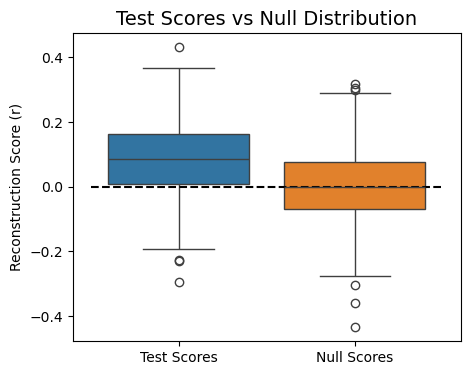

In [50]:
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=scores_dict, ax=ax)
ax.set_ylabel('Reconstruction Score (r)')
ax.set_title('Test Scores vs Null Distribution', fontsize=14)
ax.hlines(0, -0.5, 1.5, colors='k', linestyles='dashed')

In [51]:
print("EEG_train shape:", eeg_train.shape)
print("env_train shape:", env_train.shape)

print("EEG_test_window shape:", eeg_test_windows[0].shape)
print("env_test_window shape:", env_test_windows[0].shape)

print("Correlation between true and null envelope:",
      np.corrcoef(env_test_windows[0], env_test_windows_null[0])[0,1])


EEG_train shape: (31, 121570)
env_train shape: (1, 121570)
EEG_test_window shape: (31, 1280)
env_test_window shape: (1, 1280)
Correlation between true and null envelope: 0.08131715635095728


In [52]:
print(f"Test Scores 长度: {len(all_scores_flattened)}")
print(f"Null Scores 长度: {len(all_null_scores_flattened)}")

Test Scores 长度: 495
Null Scores 长度: 495


Here, we test the statistical significance

In [53]:
pg.wilcoxon(all_scores_flattened, all_null_scores_flattened)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,27678.0,two-sided,3.512654e-26,0.549071,0.69821


# 10. ⏱️ Study the Effect of Window Size

Here, we want to see how different window sizes (or "chunk lengths") affect the reconstruction scores.



Intuitively, a longer window might provide more information and lead to a better score, but it also results in fewer samples to average over. A shorter window gives us more samples, but each one might be less reliable.

To find the "sweet spot," we will create and evaluate test sets using several different window lengths.

In [37]:
window_lengths = [1, 2, 5, 10, 20]

In [38]:
# 1. Get a list of (eeg, env) pairs for each window length
windowed_data = [get_data_windows(eeg_test, env_test, window_len=w, Fs=Fs) for w in window_lengths]

# 2. "Unzip" the list of pairs into two separate lists
eeg_diff_windows, env_diff_windows = zip(*windowed_data)

In [39]:
windowed_mean_scores = []
windowed_std_scores = []
for i, w in enumerate(window_lengths):
    eeg_windows = eeg_diff_windows[i]
    env_windows = env_diff_windows[i]
    test_scores_w = [ridge.score(np.array(eeg_windows[j]).T, np.array(env_windows[j]).T) for j in range(len(eeg_windows))]
    test_scores_w = np.array(test_scores_w).flatten()

    windowed_mean_scores.append(np.mean(test_scores_w))
    windowed_std_scores.append(np.std(test_scores_w))

    print(f'Window Length: {w} sec - Mean Reconstruction Score: {np.mean(test_scores_w):.4f} ± {np.std(test_scores_w):.4f}')

Window Length: 1 sec - Mean Reconstruction Score: 0.1024 ± 0.3669
Window Length: 3 sec - Mean Reconstruction Score: 0.1134 ± 0.2096
Window Length: 5 sec - Mean Reconstruction Score: 0.1054 ± 0.1648
Window Length: 10 sec - Mean Reconstruction Score: 0.1109 ± 0.1247
Window Length: 20 sec - Mean Reconstruction Score: 0.1131 ± 0.0905
Window Length: 30 sec - Mean Reconstruction Score: 0.1106 ± 0.0602
Window Length: 45 sec - Mean Reconstruction Score: 0.1094 ± 0.0607
Window Length: 60 sec - Mean Reconstruction Score: 0.1031 ± 0.0248


In [40]:
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(window_lengths, windowed_mean_scores, yerr=windowed_std_scores, marker='o', capsize=5)
ax.set_xlabel('Window Length (seconds)')
ax.set_ylabel('Mean Reconstruction Score (r)')
ax.set_title('Effect of Window Length on Reconstruction Score', fontsize=14)

Text(0.5, 1.0, 'Effect of Window Length on Reconstruction Score')